In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
# from carps.analysis.process_data import get_interpolated_performance_df, load_logs, process_logs
from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df, load_logs, process_logs


def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print(df_trials["scenario"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


# rundir = "../runs"
# df, df_cfg = load_logs(rundir=rundir)
# df = pd.read_csv("../logs_combined.csv")
# df_cfg = pd.read_csv("../logs_combined_cfg.csv")

paths = {
    "BBsubset": [
        "../runs_subset/SMAC3-BlackBoxFacade",
        "../runs_subset/SMAC3-1.4-BlackBoxFacade",
        "../runs_subset/SMAC3-HPOFacade",
        "../runs_subset/RandomSearch",
        "../runs_subset/Optuna",
        "../runs_subset/HEBO",
        "../runs_subset/Scikit_Optimize",
        "../runs_subset/SyneTune-BO",
        "../runs_subset/Nevergrad-CMA-ES",
    ],
    "BBfull": [
        "../runs/SMAC3-BlackBoxFacade",
        "../runs/RandomSearch",
        "../runs/Nevergrad-CMA-ES",
    ]
}
subset = "BBsubset"
df = pd.concat([pd.read_parquet(Path(p) / "logs.parquet") for p in paths[subset]]).reset_index(drop=True)
df_cfg = pd.concat([pd.read_parquet(Path(p) / "logs_cfg.parquet") for p in paths[subset]]).reset_index(drop=True)




df = normalize_logs(df)
print_overview(df)
perf = get_interpolated_performance_df(df)
perf_time = get_interpolated_performance_df(df, x_column="time_norm")


[01:40:41] INFO     Start normalization...                                                       ]8;id=381882;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=330436;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#310\310]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=57184;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=38083;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#311\311]8;;\

           INFO     Normalize cost...                                                            ]8;id=139528;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=96984;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#313\313]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=5961;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=383809;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#315\315]8;;\

           INFO     Normalize time...                                                            ]8;id=928798;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=586815;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#317\317]8;;\

[01:40:43] INFO     Done.                                                                        ]8;id=151421;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=370859;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#320\320]8;;\

Index(['n_trials', 'n_function_calls', 'trial_info__config',
       'trial_info__instance', 'trial_info__seed', 'trial_info__budget',
       'trial_info__normalized_budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.model_id',
       'problem.dataset_id', 'problem.surrogates_dir', 'trial_value__cost_raw',
       'trial_value__cost_inc', 'scenario', 'time', 'problem.bench',
       'problem.instance', 'problem.budget_type', 'problem.metric',
       'problem.dimension', 'problem.fid', 'problem.seed', 'experiment_id',
       'n_trials_norm', 'trial_value__cost_norm', 'trial_value__cost_inc_norm',
       'time_norm'],
      dtype='object')
['SMAC3-BlackBoxFacade' 'SMAC3-1.4-BlackBoxFacade' 'SMAC3-HPOFacade'
 'RandomSearch' 'Optuna' 'HEBO' 'Scikit_Optimize'

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=961184;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=759551;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#359\359]8;;\
                    budget.                                                                                        

[01:40:46] INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=862665;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=51333;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/gather_data.py#359\359]8;;\
                    budget.                                                                                        

--------------------------------------------------
blackbox


[01:47:40] INFO     Lost following experiments: optimizer_id                              HEBO  ]8;id=746102;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py\run_autorank.py]8;;\:]8;id=515195;file:///scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py#104\104]8;;\
                    Nevergrad-CMA-ES  Optuna  \                                                                    
                    problem_id                                                                                     
                    blackbox/40/yahpo/rbv2_ranger/41166/None   NaN         -0.620640     NaN                       
                    blackbox/40/yahpo/rbv2_ranger/469/None     NaN         -0.270317     NaN                       
                                                                                                                   
                    optimizer_id                              RandomSearch  \                                      
                    problem_id                                                                                     
                    blackbox/40/yahpo/rbv2_ranger/41166/None     -0.712124                                         
                    blackbox/40/yahpo/rbv2_ranger/469/None       -0.305371                                         
                                                                                                                   
                    optimizer_id                              SMAC3-1.4-BlackBoxFacade  \                          
                    problem_id                                                                                     
                    blackbox/40/yahpo/rbv2_ranger/41166/None                 -0.919344                             
                    blackbox/40/yahpo/rbv2_ranger/469/None                   -0.573023                             
                                                                                                                   
                    optimizer_id                              SMAC3-BlackBoxFacade  \                              
                    problem_id                                                                                     
                    blackbox/40/yahpo/rbv2_ranger/41166/None             -0.923123                                 
                    blackbox/40/yahpo/rbv2_ranger/469/None               -0.537029                                 
                                                                                                                   
                    optimizer_id                              SMAC3-HPOFacade  Scikit_Optimize                     
                    \                                                                                              
                    problem_id                                                                                     
                    blackbox/40/yahpo/rbv2_ranger/41166/None        -0.763972              NaN                     
                    blackbox/40/yahpo/rbv2_ranger/469/None          -0.318140              NaN                     
                                                                                                                   
                    optimizer_id                              SyneTune-BO                                          
                    problem_id                                                                                     
                    blackbox/40/yahpo/rbv2_ranger/41166/None          NaN                                          
                    blackbox/40/yahpo/rbv2_ranger/469/None            NaN                                          

Rejecting null hypothesis that data is normal for column HEBO (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column Nevergrad-CMA-ES (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column Optuna (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column RandomSearch (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column SMAC3-1.4-BlackBoxFacade (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column SMAC3-BlackBoxFacade (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column SMAC3-HPOFacade (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column Scikit_Optimize (p=0.000000<0.005556)
Rejecting null hypothesis that data is normal for column SyneTune-BO (p=0.000000<0.005556)
Using Friedman test as omnibus test
Rejecting null hypothesis that there is no difference between the distributions (p=0.000000)
Using Nemenyi post-hoc test.

/scratch/hpc-prf-intexml/cbenjamins/.conda/envs/carpsexp/lib/python3.10/site-packages/autorank/_util.py:432: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(sorted_ranks[i] - sorted_ranks[j]) <= critical_difference:
/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py:220: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plot_line([(rankpos(sorted_ranks[i]), cline), (rankpos(sorted_ranks[i]), chei), (textspace - 0.1, chei)], linewidth=0.7)
/scratch/hpc-prf-intexml/cbenjamins/repos/CARP-S-Experiments/lib/CARP-S/carps/analysis/run_autorank.py:225: FutureWarning: Serie

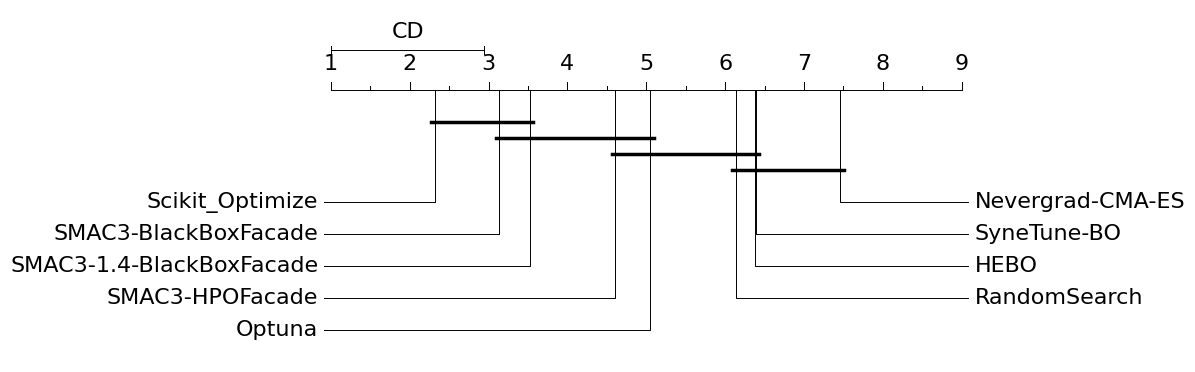


\begin{table}[h]
    \centering
    \begin{tabular}{lrrllll}
\toprule
 & MR & MED & MAD & CI & $\gamma$ & Magnitude \\
\midrule
Scikit_Optimize & 2.316 & -0.860 & 0.087 & [-0.947, -0.636] & 0.000 & negligible \\
SMAC3-BlackBoxFacade & 3.132 & -0.832 & 0.107 & [-0.940, -0.622] & -0.196 & negligible \\
SMAC3-1.4-BlackBoxFacade & 3.526 & -0.832 & 0.110 & [-0.941, -0.575] & -0.192 & negligible \\
SMAC3-HPOFacade & 4.605 & -0.832 & 0.105 & [-0.937, -0.553] & -0.198 & negligible \\
Optuna & 5.053 & -0.832 & 0.105 & [-0.937, -0.551] & -0.198 & negligible \\
RandomSearch & 6.132 & -0.816 & 0.115 & [-0.937, -0.551] & -0.290 & small \\
HEBO & 6.382 & -0.832 & 0.106 & [-0.937, -0.539] & -0.197 & negligible \\
SyneTune-BO & 6.395 & -0.832 & 0.110 & [-0.937, -0.551] & -0.192 & negligible \\
Nevergrad-CMA-ES & 7.461 & -0.815 & 0.121 & [-0.937, -0.510] & -0.286 & small \\
\bottomrule
\end{tabular}
    \caption{Summary of populations}
    \label{stat_results_blackbox}
\end{table}



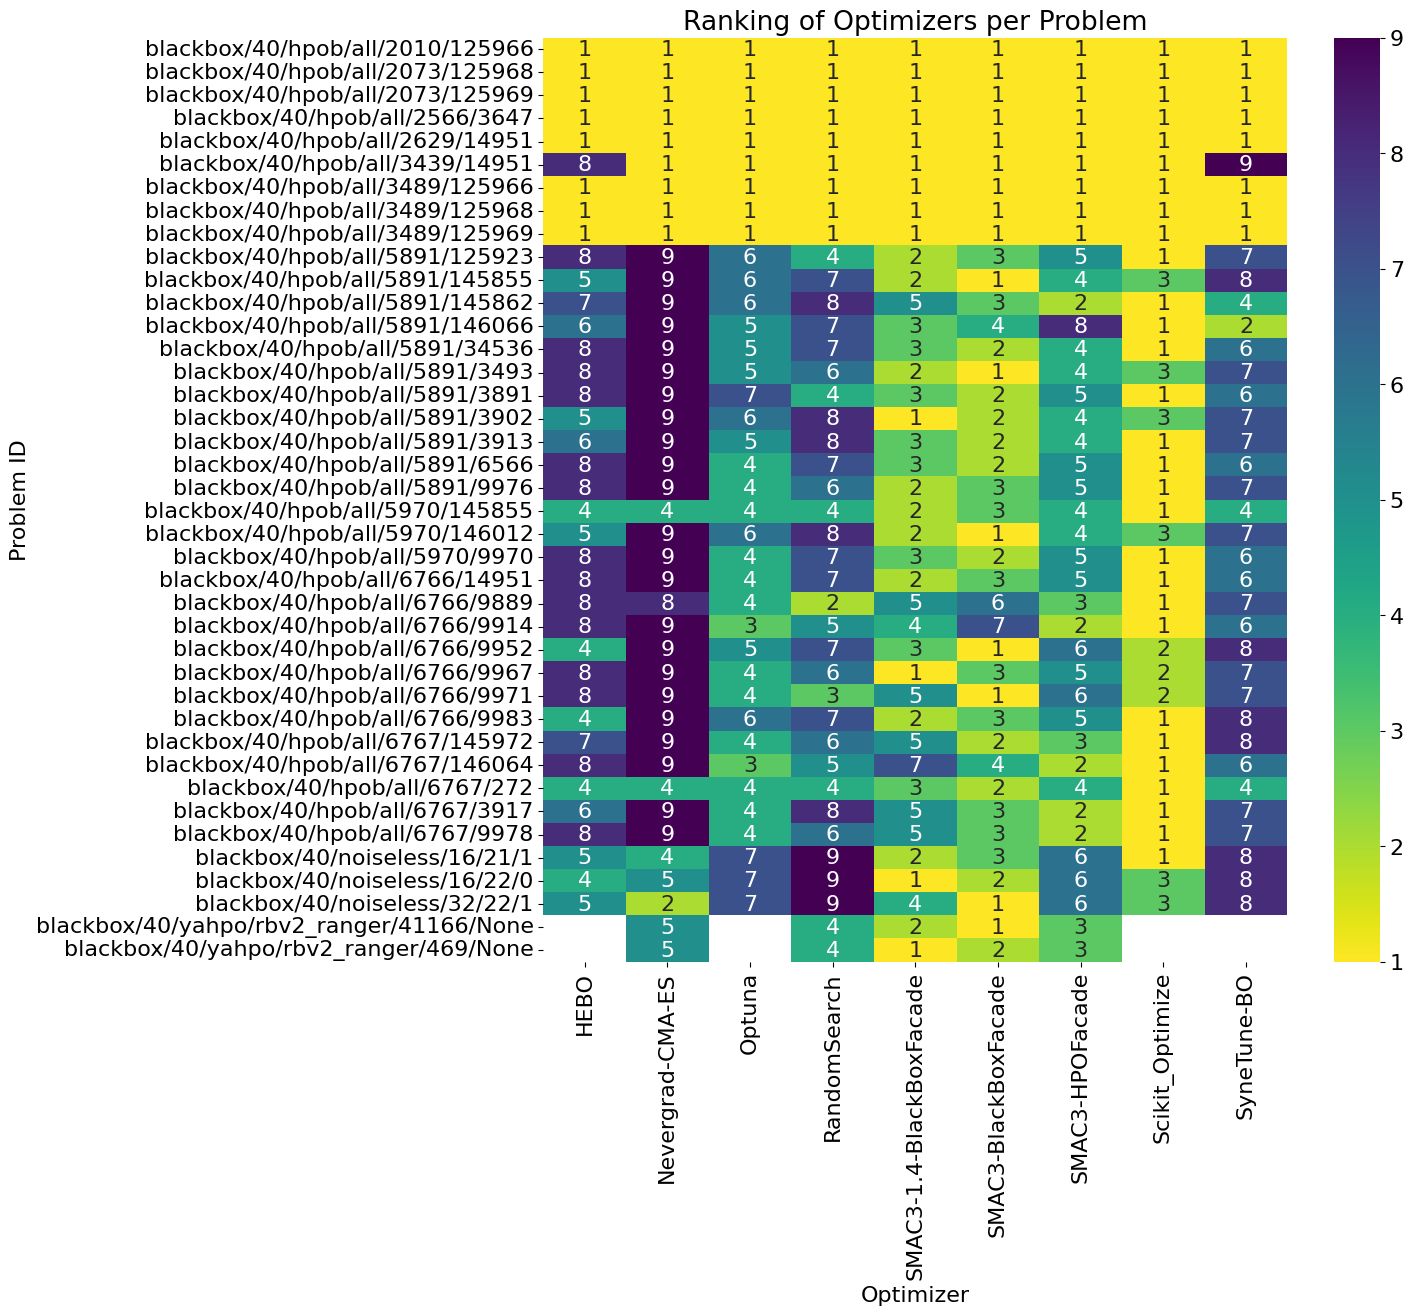

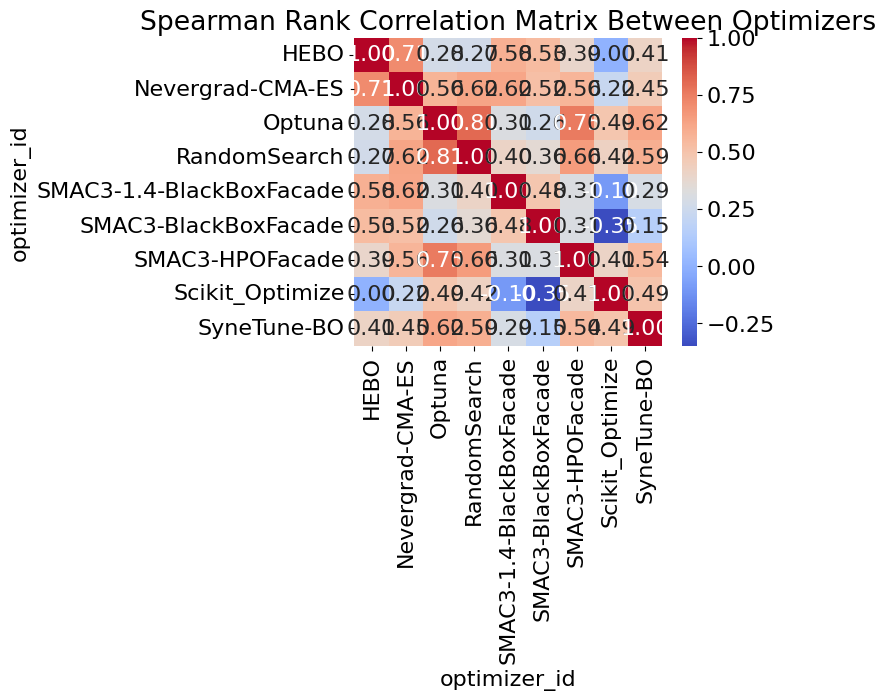

--------------------------------------------------
multi-fidelity


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats, create_report, latex_table
from carps.analysis.run_autorank import calc_critical_difference, custom_latex_table, get_df_crit
from carps.analysis.utils import savefig
import seaborn as sns

scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    print("-"*50)
    print(scenario)
    df_scenario = df[df["scenario"]==scenario]
    if len(df_scenario) > 0:
        label = f"stat_results_{scenario}"
        result = calc_critical_difference(df_scenario, identifier=scenario, figsize=(12,4))
        table_str = custom_latex_table(result, label=label)
        fn = Path(label + ".tex")
        fn.write_text(table_str)
        print(table_str)
        plt.show()


        # Optionally, plot the ranked data as a heatmap
        df_crit = get_df_crit(df, remove_nan=False)
        ranked_df = df_crit.rank(axis=1, method='min', ascending=True)

        plt.figure(figsize=(12, 12))
        sns.heatmap(ranked_df, annot=True, fmt="g", cmap='viridis_r')
        plt.title('Ranking of Optimizers per Problem')
        plt.ylabel('Problem ID')
        plt.xlabel('Optimizer')
        savefig(plt.gcf(), f"rank_opt_per_problem_{scenario}")
        plt.show()

        # Plotting the heatmap of the rank correlation matrix
        correlation_matrix = ranked_df.corr(method='spearman')
        plt.figure(figsize=(8,6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt=".2f")
        plt.title('Spearman Rank Correlation Matrix Between Optimizers')
        savefig(plt.gcf(), f"spearman_rank_corr_matrix_opt_{scenario}")
        plt.show()

In [4]:
ranked_df

optimizer_id,HEBO,Nevergrad-CMA-ES,Optuna,RandomSearch,SMAC3-1.4-BlackBoxFacade,SMAC3-BlackBoxFacade,SMAC3-HPOFacade,Scikit_Optimize,SyneTune-BO
problem_id,,,,,,,,,
blackbox/40/hpob/all/2010/125966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/2073/125968,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/2073/125969,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/2566/3647,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/2629/14951,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/3439/14951,8.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9.0
blackbox/40/hpob/all/3489/125966,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/3489/125968,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
blackbox/40/hpob/all/3489/125969,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [3]:

# fig, axes = plot_interval_estimates(performance_data=perf, load_from_pickle=False, figure_filename="figures/plot_interval_estimates.pdf")

/tmp/ipykernel_137534/1549615404.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x=x, y=y, hue=hue, palette=palette, **lineplot_kwargs, ax=ax)
/tmp/ipykernel_137534/1549615404.py:13: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x=x, y=y, hue=hue, palette=palette, **lineplot_kwargs, ax=ax)


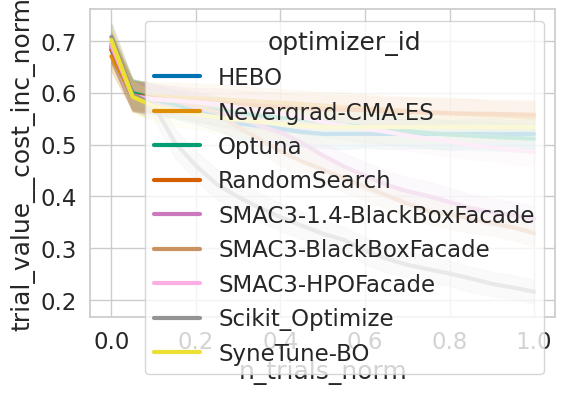

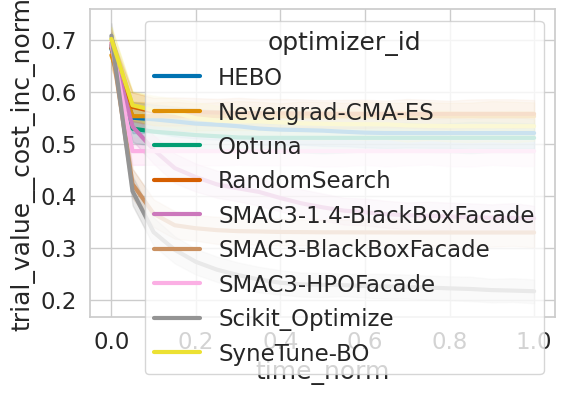

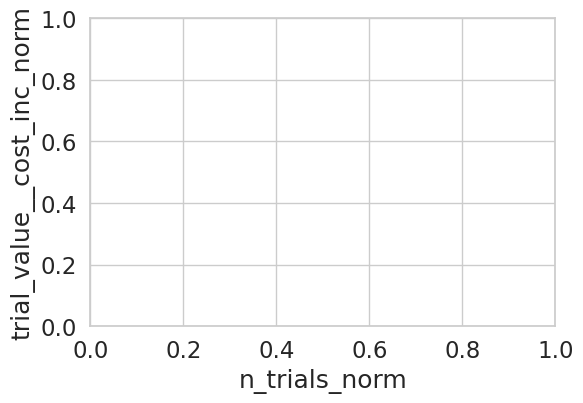

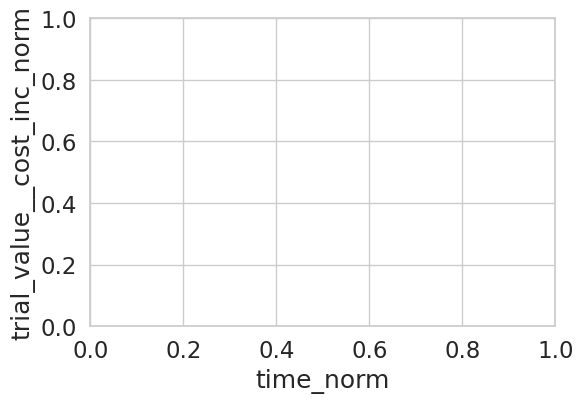

In [4]:
from carps.analysis.performance_over_time import plot_performance_over_time, setup_seaborn, savefig, get_color_palette
import seaborn as sns
import matplotlib
lineplot_kwargs = dict(linewidth=3)
scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    def plot_performance_over_time(df: pd.DataFrame, x="n_trials_norm", y="cost_inc_norm", hue="optimizer_id", figure_filename: str = "figures/performance_over_time.pdf", figsize: tuple[int,int]=(6,4), **lineplot_kwargs
                               ) -> tuple[plt.Figure, matplotlib.axes.Axes]:
        setup_seaborn(font_scale=1.5)
        palette = get_color_palette(df)
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax = sns.lineplot(data=df, x=x, y=y, hue=hue, palette=palette, **lineplot_kwargs, ax=ax)
        
        savefig(fig, figure_filename)

        return fig, ax
    fig, ax = plot_performance_over_time(
        df=perf[perf["scenario"]==scenario], 
        x="n_trials_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/performance_over_time_{scenario}_trials.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )
    fig, ax = plot_performance_over_time(
        df=perf_time[perf_time["scenario"]==scenario], 
        x="time_norm", 
        y="trial_value__cost_inc_norm", 
        hue="optimizer_id", 
        figure_filename=f"figures/performance_over_time_{scenario}_elapsed.pdf", 
        figsize=(6,4), 
        **lineplot_kwargs
    )

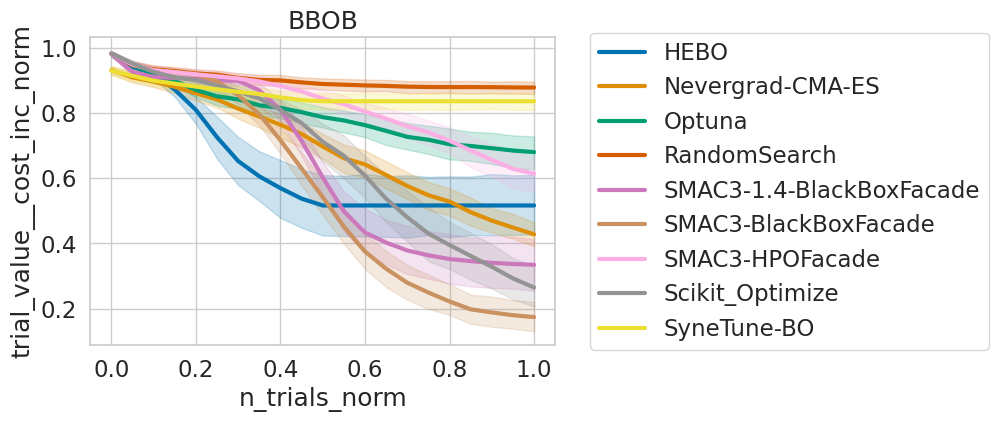

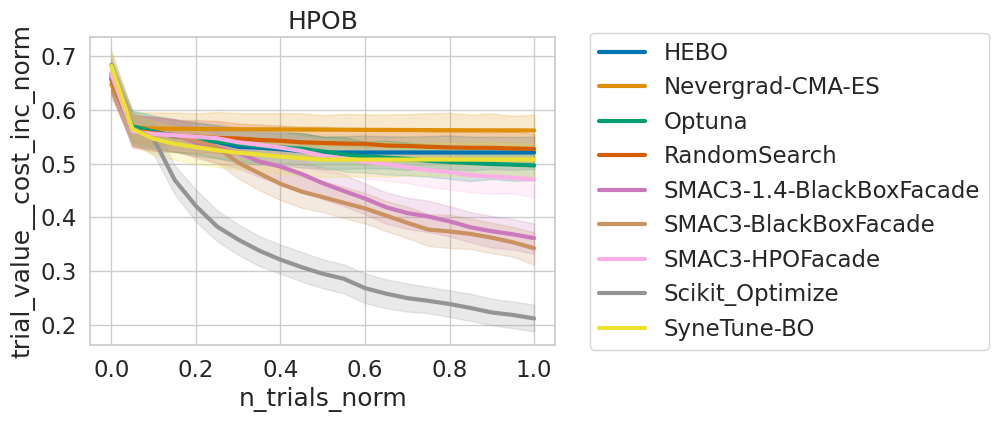

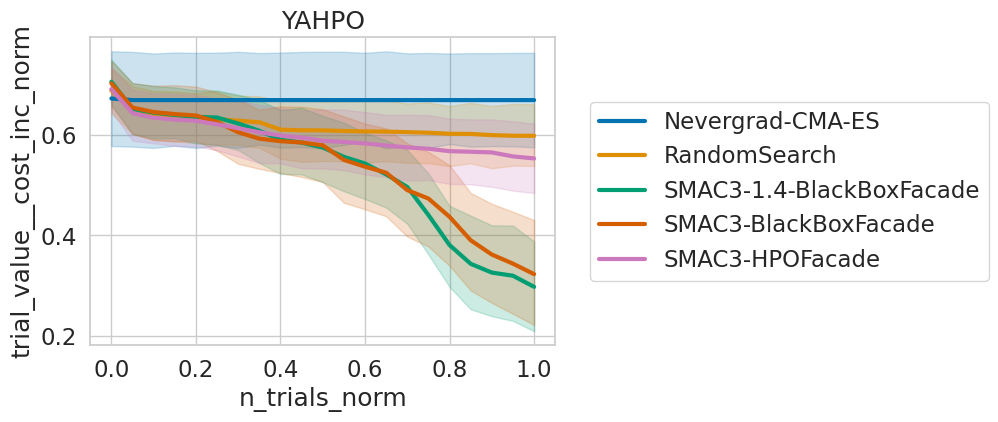

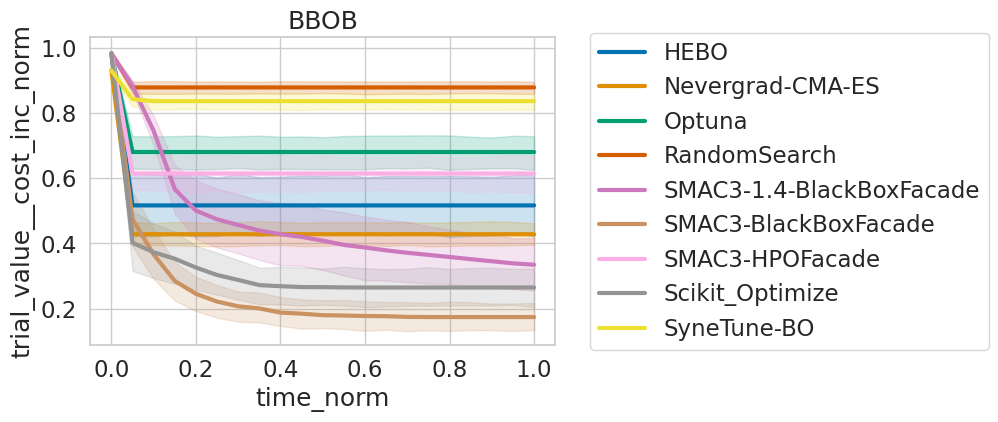

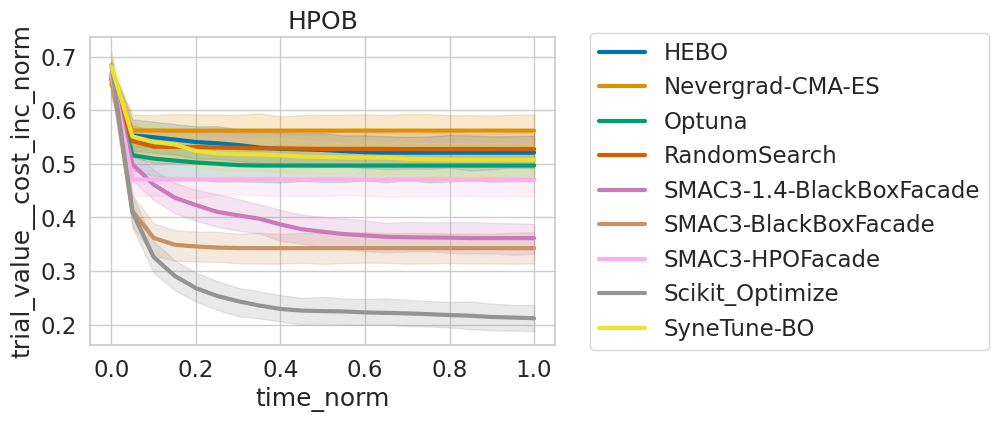

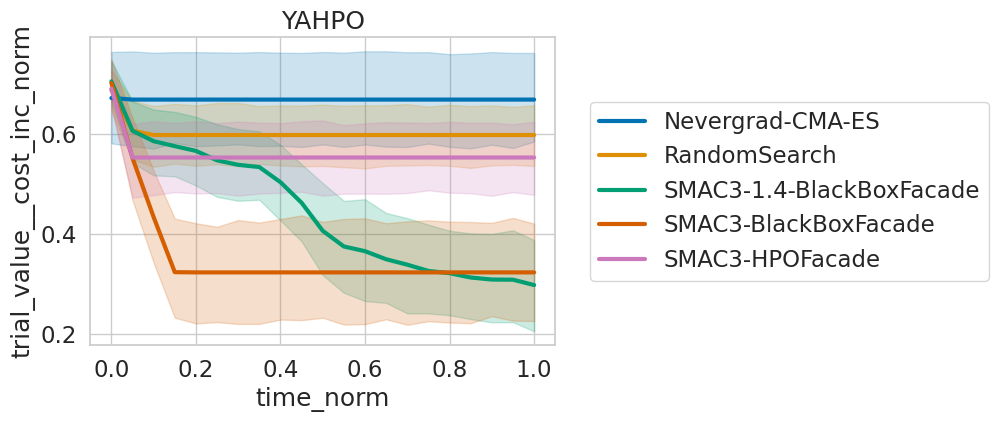

In [5]:
# Plot per benchmark
from carps.analysis.utils import get_color_palette, savefig
from carps.analysis.performance_over_time import plot_performance_over_time

palette = get_color_palette(perf)
lineplot_kwargs = dict(linewidth=3)

scenarios = ["blackbox", "multi-fidelity"]

for scenario in scenarios:
    _perf = perf[perf["scenario"]==scenario]
    _perf_time = perf_time[perf_time["scenario"]==scenario]
    # Iterations
    for gid, gdf in _perf.groupby(by="benchmark_id"):    
        figure_filename = f"figures/performance_over_time_trials_{scenario}_{gid}.pdf"
        fig, ax = plot_performance_over_time(df=gdf, x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
        ax.set_title(gid)
        savefig(fig, figure_filename)
        plt.show()

    # Elapsed time
    for gid, gdf in _perf_time.groupby(by="benchmark_id"):    
        figure_filename = f"figures/performance_over_time_elapsed_{scenario}_{gid}.pdf"
        fig, ax = plot_performance_over_time(df=gdf, x="time_norm", y="trial_value__cost_inc_norm", hue="optimizer_id", figure_filename=figure_filename, figsize=(6,4), **lineplot_kwargs)
        ax.set_title(gid)
        savefig(fig, figure_filename)
        plt.show()

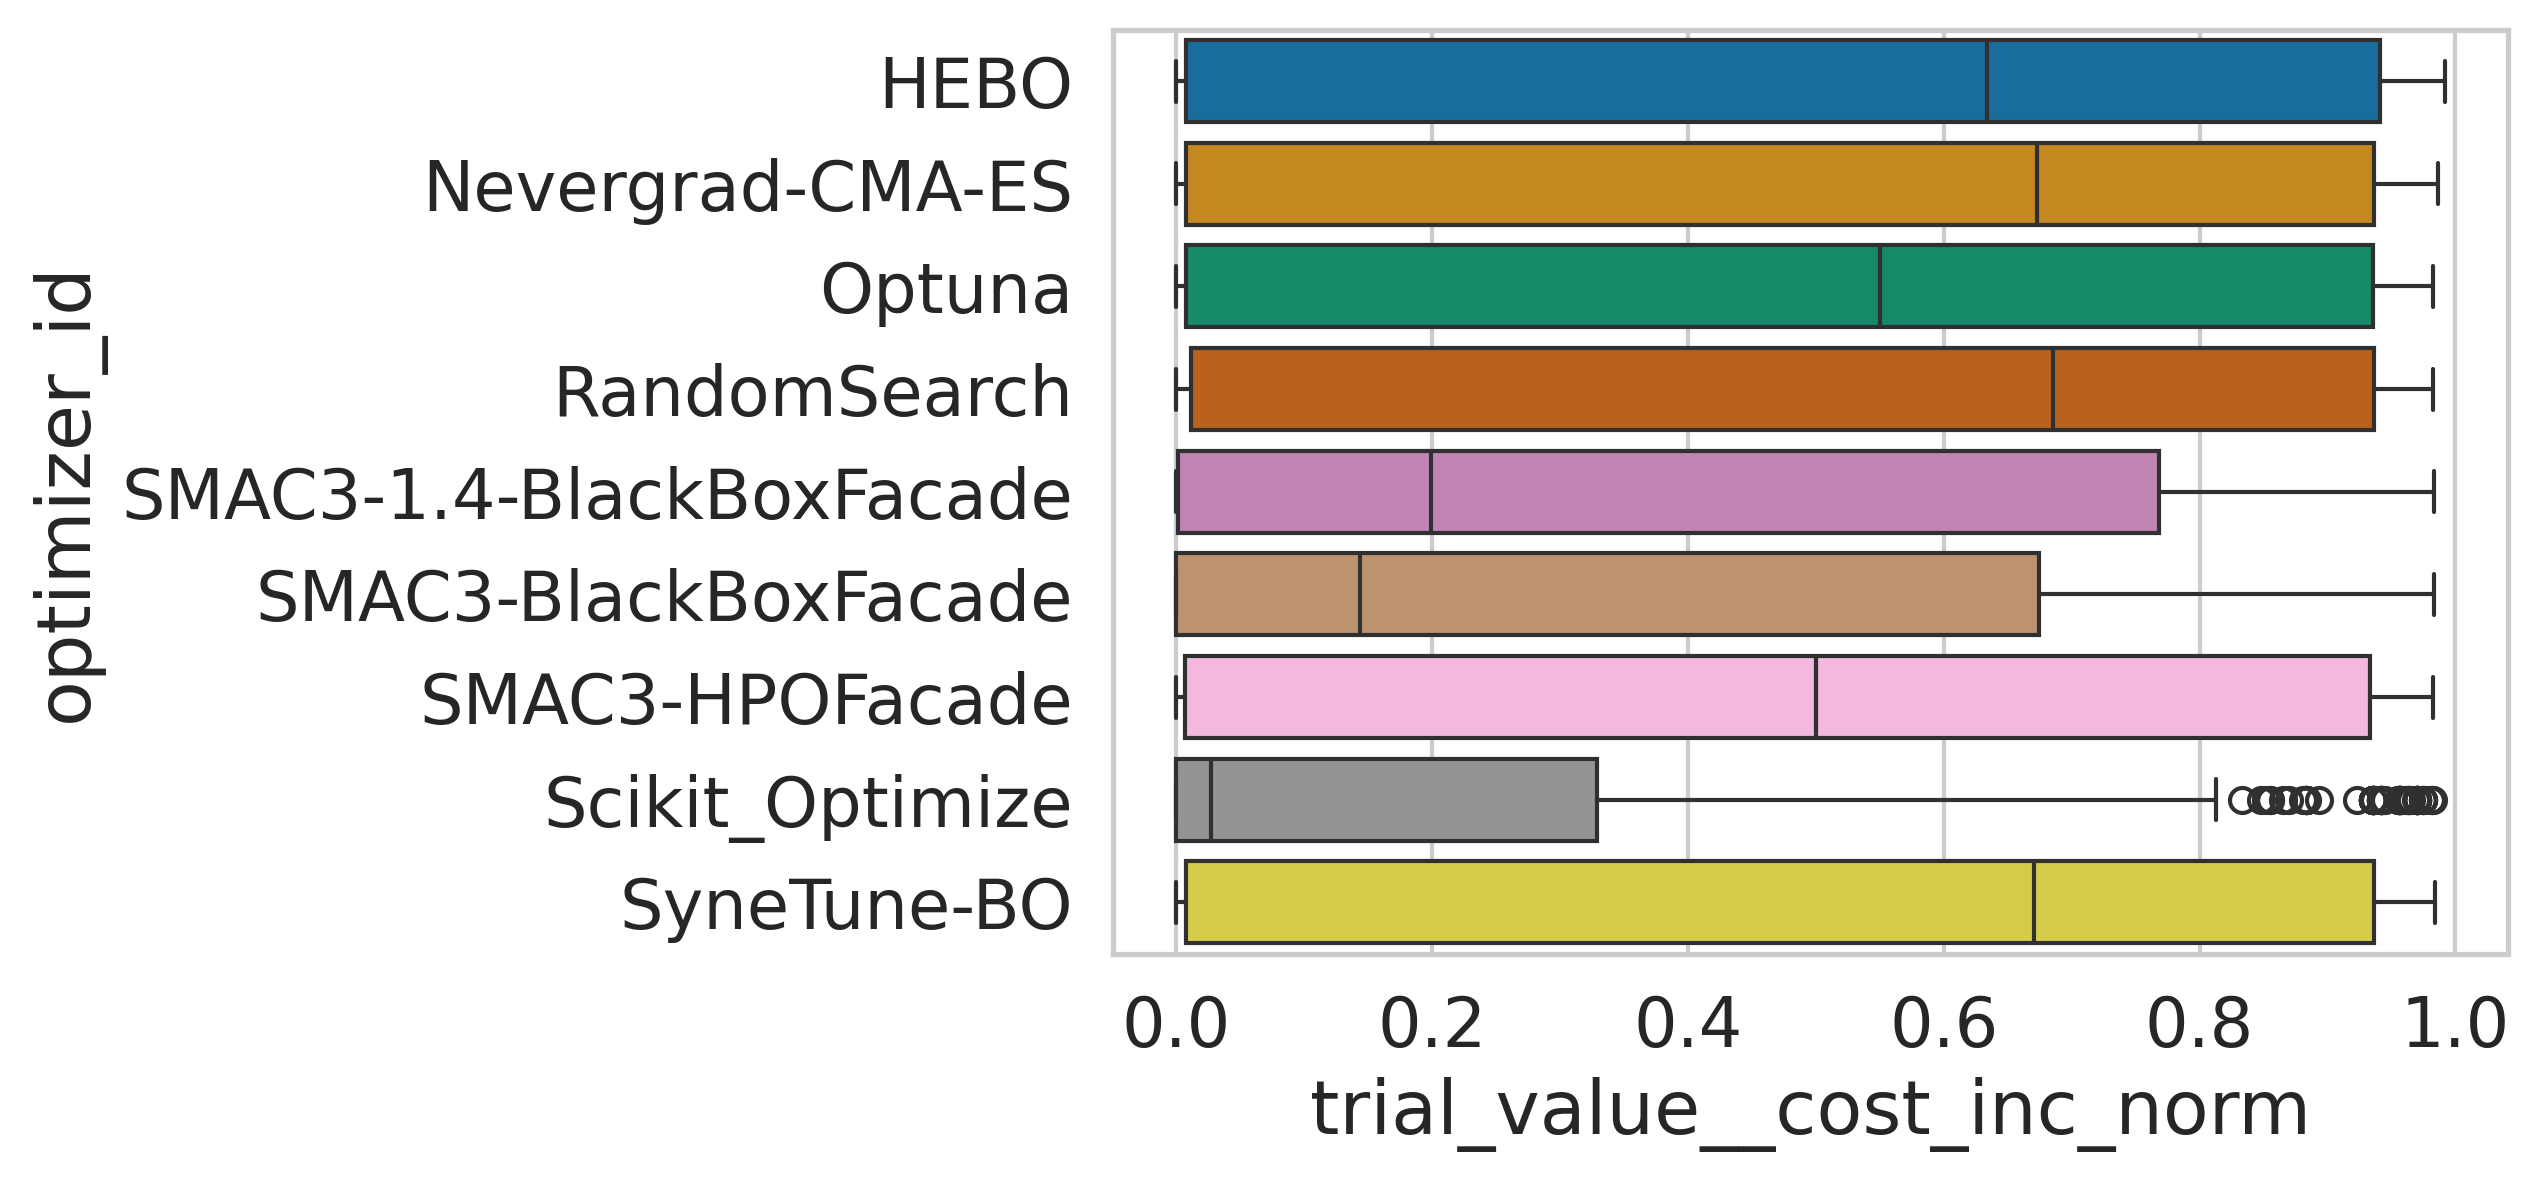

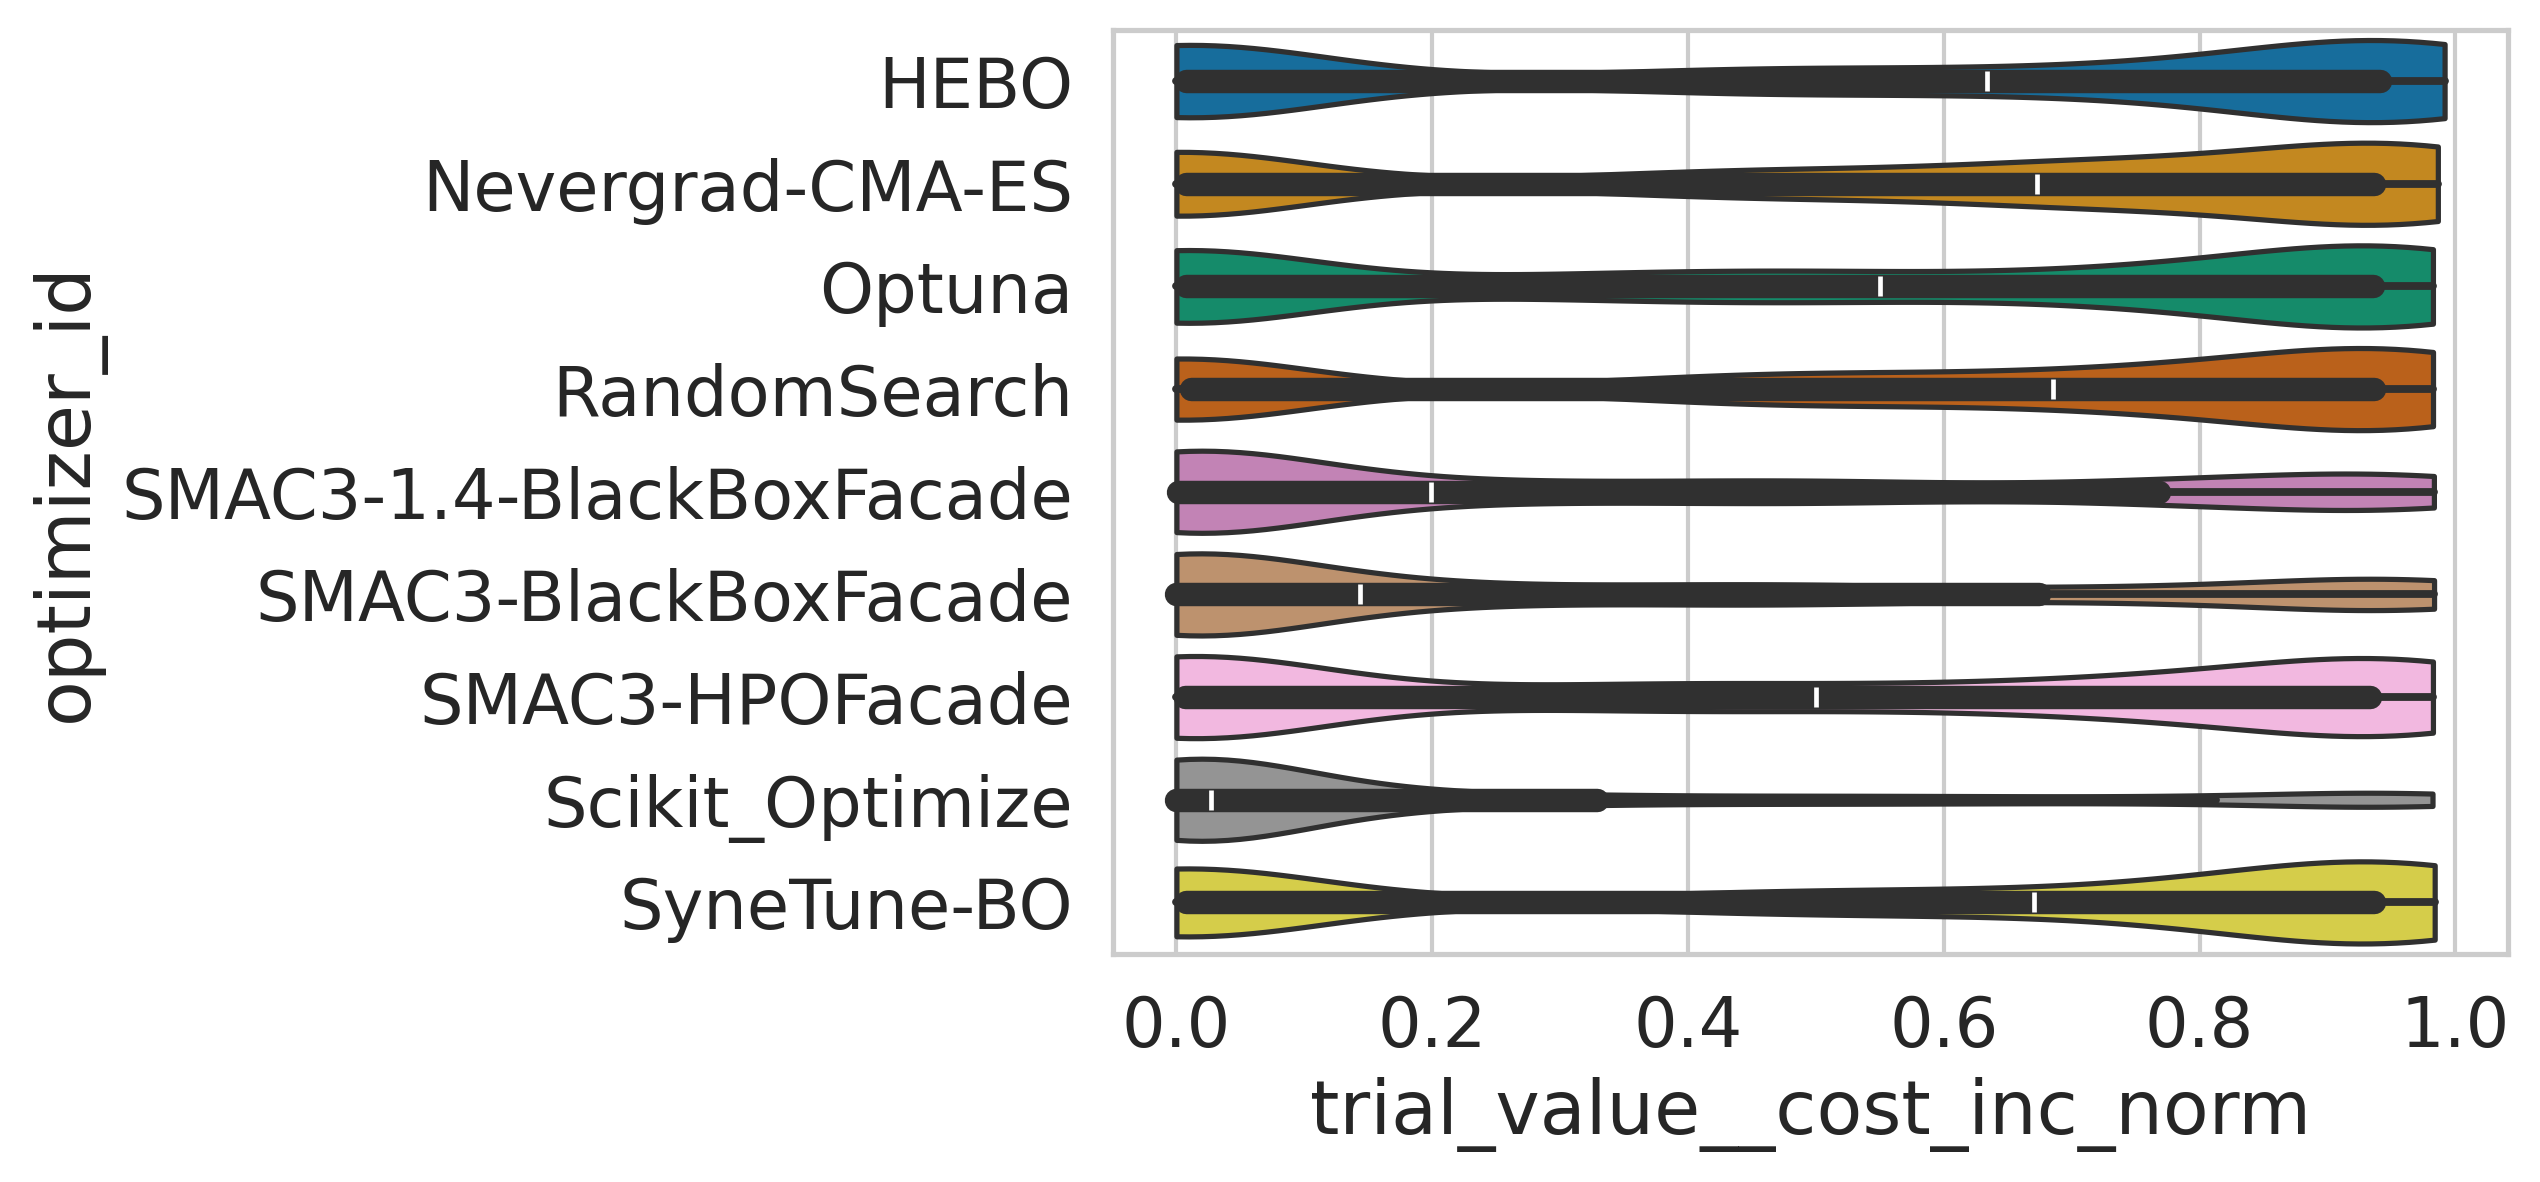

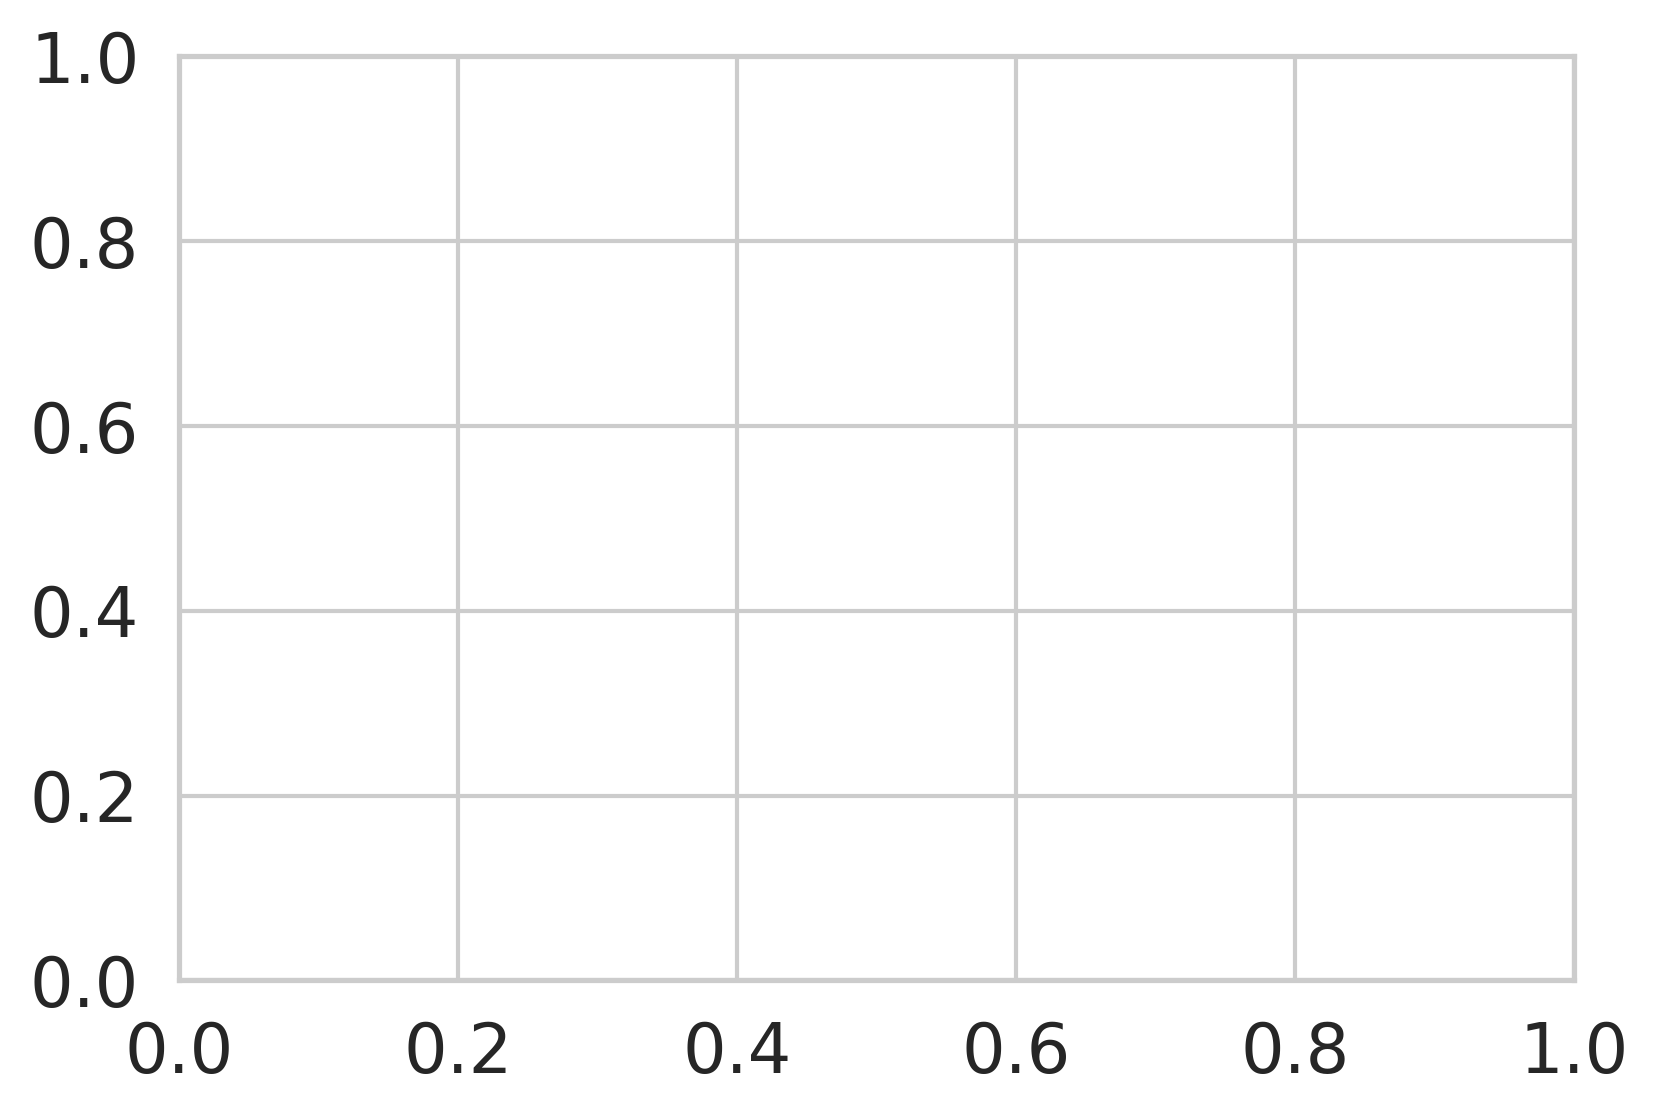

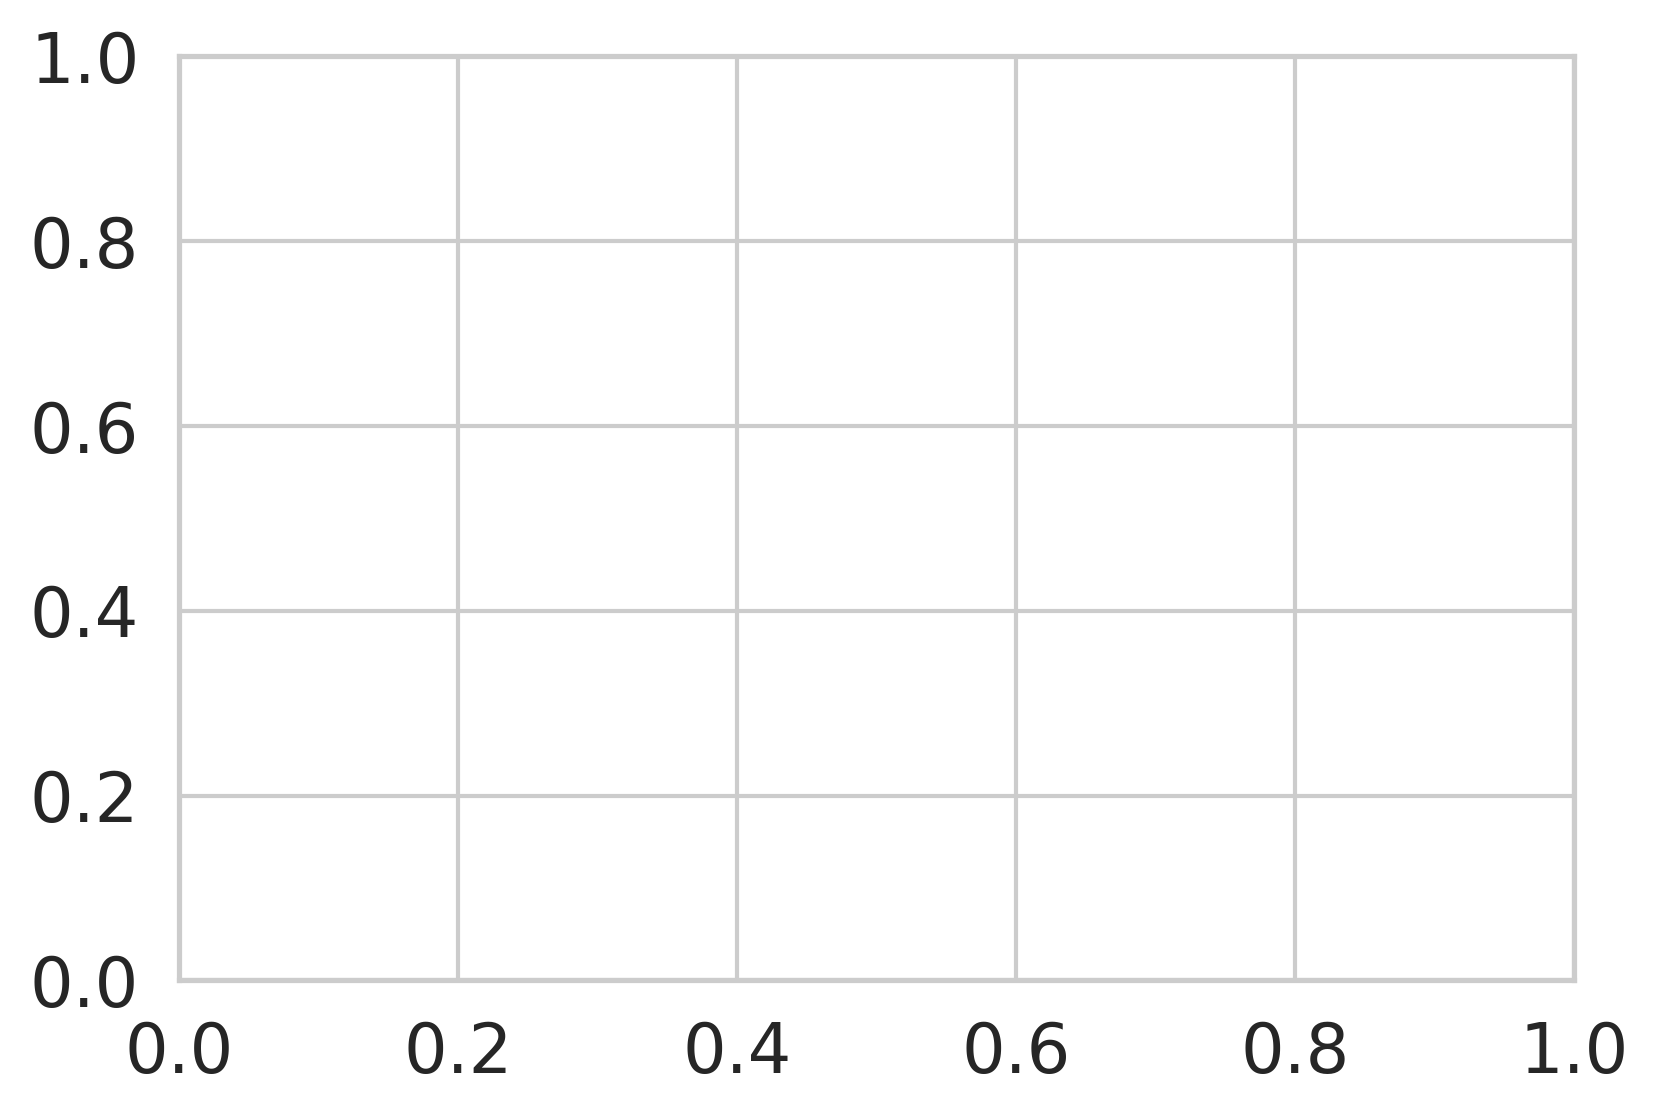

In [6]:
from carps.analysis.final_performance import plot_final_performance_boxplot, plot_final_performance_violinplot

boxplot_kwargs = dict()

scenarios = ["blackbox", "multi-fidelity"]
for scenario in scenarios:
    fig, ax = plot_final_performance_boxplot(
        df=perf[perf["scenario"]==scenario], 
        x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename=f"figures/final_performance_boxplot_{scenario}.pdf", figsize=(6,4), **boxplot_kwargs)
    fig, ax = plot_final_performance_violinplot(
        df=perf[perf["scenario"]==scenario], 
        x="trial_value__cost_inc_norm", y="optimizer_id", hue="optimizer_id", figure_filename=f"figures/final_performance_violinplot_{scenario}.pdf", figsize=(6,4), **boxplot_kwargs)

In [7]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 1)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 2)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 3)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 4)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 5)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 6)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 7)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 8)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 9)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 10)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 11)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 12)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 13)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 14)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 15)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 16)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 17)
('BBOB', 'blackbox/40/noiseless/16/21/1', 'HEBO', 18)
('BBOB', 'blackbox/40/noiseless/16/21